# CoxPH-Lasso on top EWAS results

```{contents}
```

## Load Data

In [1]:
import pandas as pd

input_path = '../Data/Intermediate_Files/'
clinical_data_path = '../Data/Raw_Data/Clinical_Data/'
output_path = '../Data/Processed_Data/'


df_methyl = pd.read_pickle(
    input_path+'df_batch_uncorrected.pkl').sort_index()



# Import functions to clean up clinical data
from FM_Functions.Clinical_Data_CleanUp import *

# Call functions to merge, index and clean clinical data files
labels_0531         = clean_cog       (merge_index_0531())
labels_1031         = clean_cog       (merge_index_1031())
labels_aml05        = clean_aml05     (merge_index_aml05())
labels_beataml      = clean_beataml   (merge_index_beataml())
labels_amltcga      = clean_amltcga   (merge_index_amltcga())
labels_nordic_all   = clean_nordic_all(merge_index_nordic_all())
labels_mds_taml     = clean_mds_taml  (merge_index_mds_taml())
labels_all_graal    = clean_all_graal (merge_index_all_graal())
labels_target_all   = clean_target_all(merge_index_target_all())

# Combine all clinical data labels into one dataframe
labels_combined = pd.concat([labels_aml05, labels_beataml,
                         labels_0531, labels_amltcga, labels_1031,
                        labels_nordic_all, labels_mds_taml,
                        labels_all_graal,labels_target_all], axis=0, join='outer')

# read x_top from output file
x = pd.read_pickle(output_path+'ewas_dmr/ewas_top_x.pkl')

# Remove samples that are not in the methyl dataset
df_labels = labels_combined.loc[labels_combined.index.isin(x.index)].sort_index()

print(
    f' Dataset (df) contains {x.shape[1]} columns (5mC nucleotides/probes) and {x.shape[0]} rows (samples).')

 Dataset (df) contains 167 columns (5mC nucleotides/probes) and 924 rows (samples).


## Perform multivariate CoxPH-Lasso

Here we will run on 167 CpGs that were selected from EWAS risk-adjusted OS at 1*10e-6 significance:

In [2]:
# Import functions to clean up clinical data
from FM_Functions.Cox_Lasso_Function import *

# raw_coefs = train_coxph_lasso(df=df_labels,
#                                 event= 'os.evnt',
#                                 time= 'os.time',
#                                 train_x=x,
#                                 cv_n_split=10,
#                                 loops=1000)
# raw_coefs.to_csv(output_path + 'multivariate_cox_lasso/ewas_cog_os_raw_coefs.csv')


raw_coefs = pd.read_csv(output_path + 'multivariate_cox_lasso/ewas_cog_os_raw_coefs.csv', index_col=0)

### Set Threshold

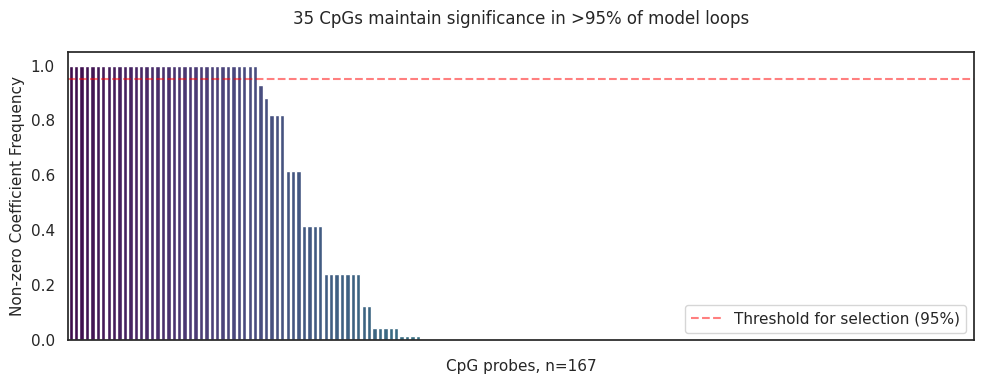

In [3]:
mean_coefs = set_cutoff(coefs=raw_coefs,threshold=0.95)
                                
plot_nonzero_coef_freq(raw_coefs, mean_coefs, threshold=0.95, savefig=False, fig_path=None, figsize=(10,4))


## Generate Model Results

### Discovery Dataset

In [4]:
score_name = 'MethylScore_CoxPH'

df, threshold = generate_coxph_score(coef_mean=mean_coefs,
                                        x=x,
                                        df=df_labels,
                                        score_name=score_name,
                                        train_test="train")

Continuous score cut at the value of 0.2208


Text(0.5, 1.0, 'Distribution of MethylScore_CoxPH in COG trials')

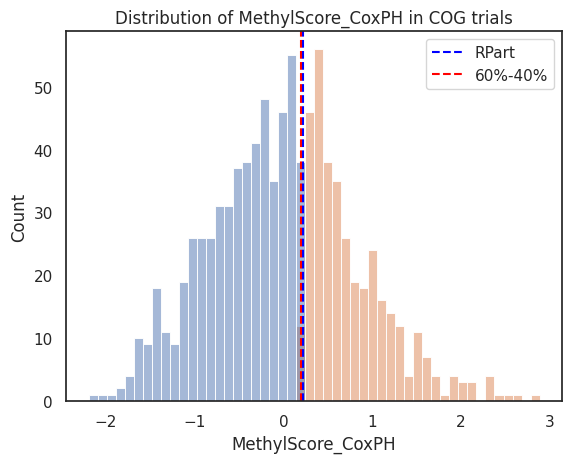

In [5]:
sns.histplot(data=df,x=score_name, bins=50, hue = score_name + ' Categorical' )

# add vertical line at threshold and third quartile
plt.axvline(threshold ,color='blue', linestyle='--')
plt.axvline(df[score_name].quantile(0.6), color='red', linestyle='--')


# add legend
plt.legend({'RPart':threshold, '60%-40%':df[score_name].quantile(0.6)})
plt.title('Distribution of ' + score_name + ' in COG trials')

## Stratify by Cytogenetics

In [6]:
df['Primary Cytogenetic Code'].value_counts()

Primary Cytogenetic Code
Other      259
Normal     217
MLL        188
t(8;21)    129
inv(16)    111
Name: count, dtype: int64

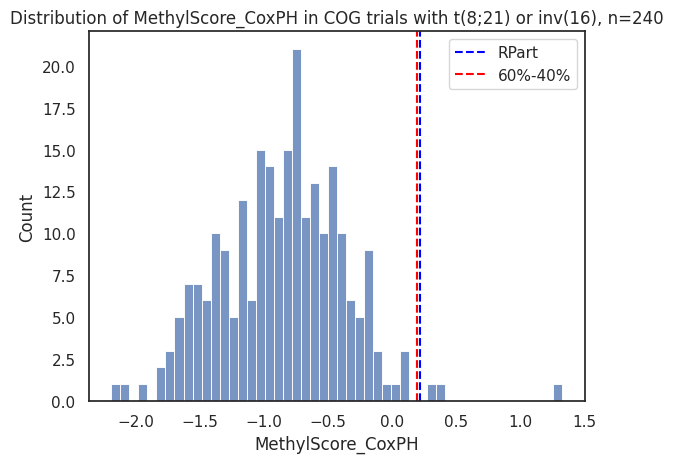

In [7]:
# Plot histogram of scores for each category in `Primary Cytogenetic Code`
sns.histplot(data=df[df['Primary Cytogenetic Code'].isin(['t(8;21)', 'inv(16)'])],x=score_name, bins=50)
plt.title('Distribution of ' + score_name + ' in COG trials with t(8;21) or inv(16), n=' + str(df[df['Primary Cytogenetic Code'].isin(['t(8;21)', 'inv(16)'])].shape[0]))

plt.axvline(threshold ,color='blue', linestyle='--')
plt.axvline(df[score_name].quantile(0.6), color='red', linestyle='--')
plt.legend({'RPart':threshold, '60%-40%':df[score_name].quantile(0.6)})

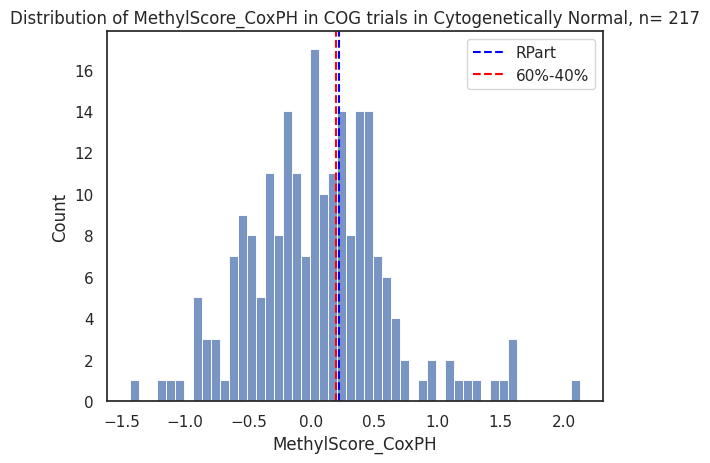

In [8]:
# Plot histogram of scores for each category in `Primary Cytogenetic Code`
sns.histplot(data=df[df['Primary Cytogenetic Code'].isin(['Normal'])],x=score_name, bins=50)
plt.title('Distribution of ' + score_name + ' in COG trials in Cytogenetically Normal, n= ' + str(df[df['Primary Cytogenetic Code'].isin(['Normal'])].shape[0]))

plt.axvline(threshold ,color='blue', linestyle='--')
plt.axvline(df[score_name].quantile(0.6), color='red', linestyle='--')
plt.legend({'RPart':threshold, '60%-40%':df[score_name].quantile(0.6)})

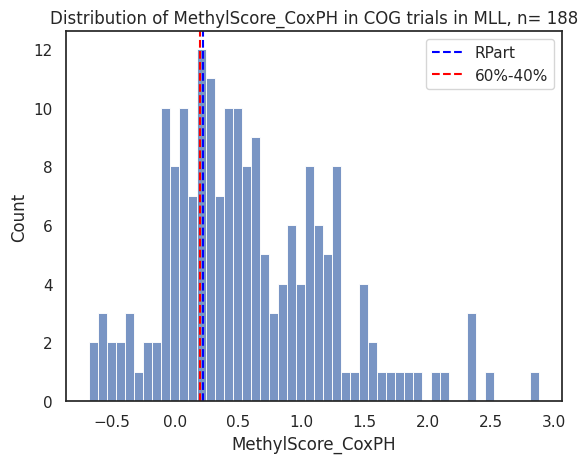

In [9]:
# Plot histogram of scores for each category in `Primary Cytogenetic Code`
sns.histplot(data=df[df['Primary Cytogenetic Code'].isin(['MLL'])],x=score_name, bins=50)
plt.title('Distribution of ' + score_name + ' in COG trials in MLL, n= ' + str(df[df['Primary Cytogenetic Code'].isin(['MLL'])].shape[0]))

plt.axvline(threshold ,color='blue', linestyle='--')
plt.axvline(df[score_name].quantile(0.6), color='red', linestyle='--')
plt.legend({'RPart':threshold, '60%-40%':df[score_name].quantile(0.6)})

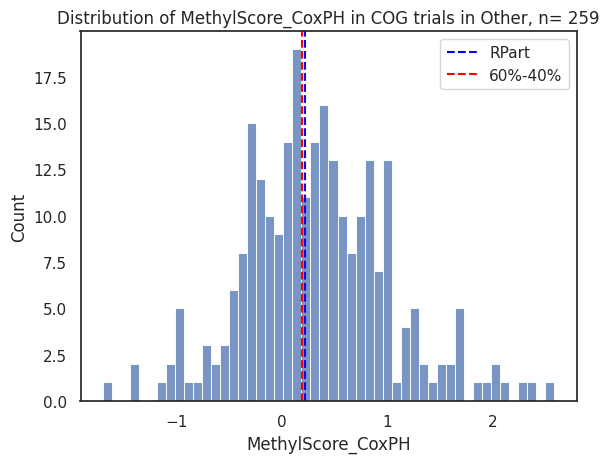

In [10]:
# Plot histogram of scores for each category in `Primary Cytogenetic Code`
sns.histplot(data=df[df['Primary Cytogenetic Code'].isin(['Other'])],x=score_name, bins=50)
plt.title('Distribution of ' + score_name + ' in COG trials in Other, n= ' + str(df[df['Primary Cytogenetic Code'].isin(['Other'])].shape[0]))

plt.axvline(threshold ,color='blue', linestyle='--')
plt.axvline(df[score_name].quantile(0.6), color='red', linestyle='--')
plt.legend({'RPart':threshold, '60%-40%':df[score_name].quantile(0.6)})

## Kaplan-Meier Plots

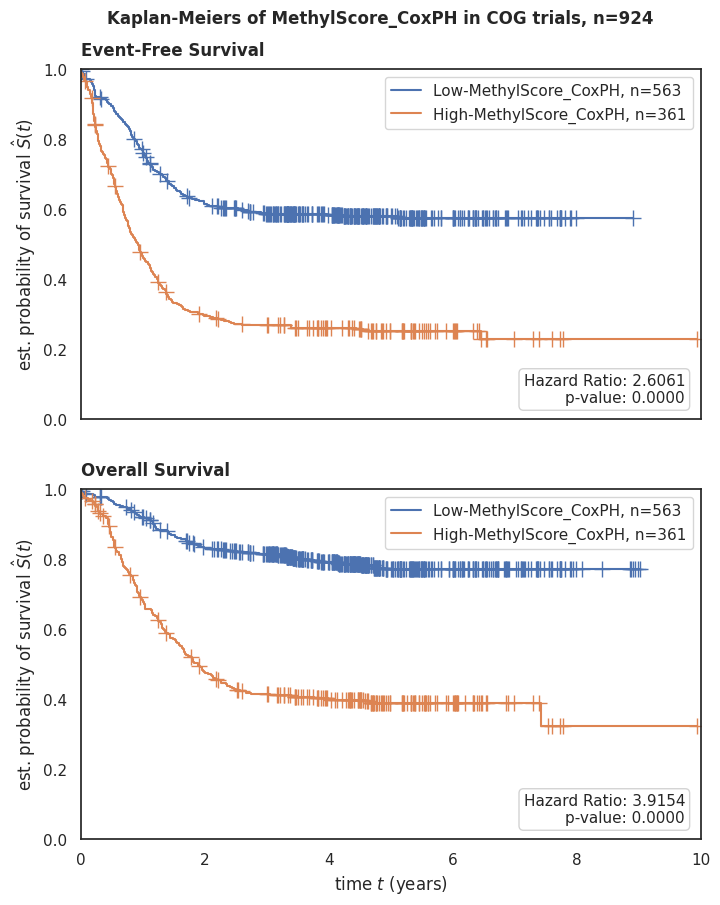

In [11]:
# Import Plotting Functions
from FM_Functions.Data_Visualization import *

draw_kaplan_meier(scorename=score_name,
                        df=df,
                        save_plot=False,
                        add_risk_counts=False,
                        trialname='COG trials')

## Forest Plots

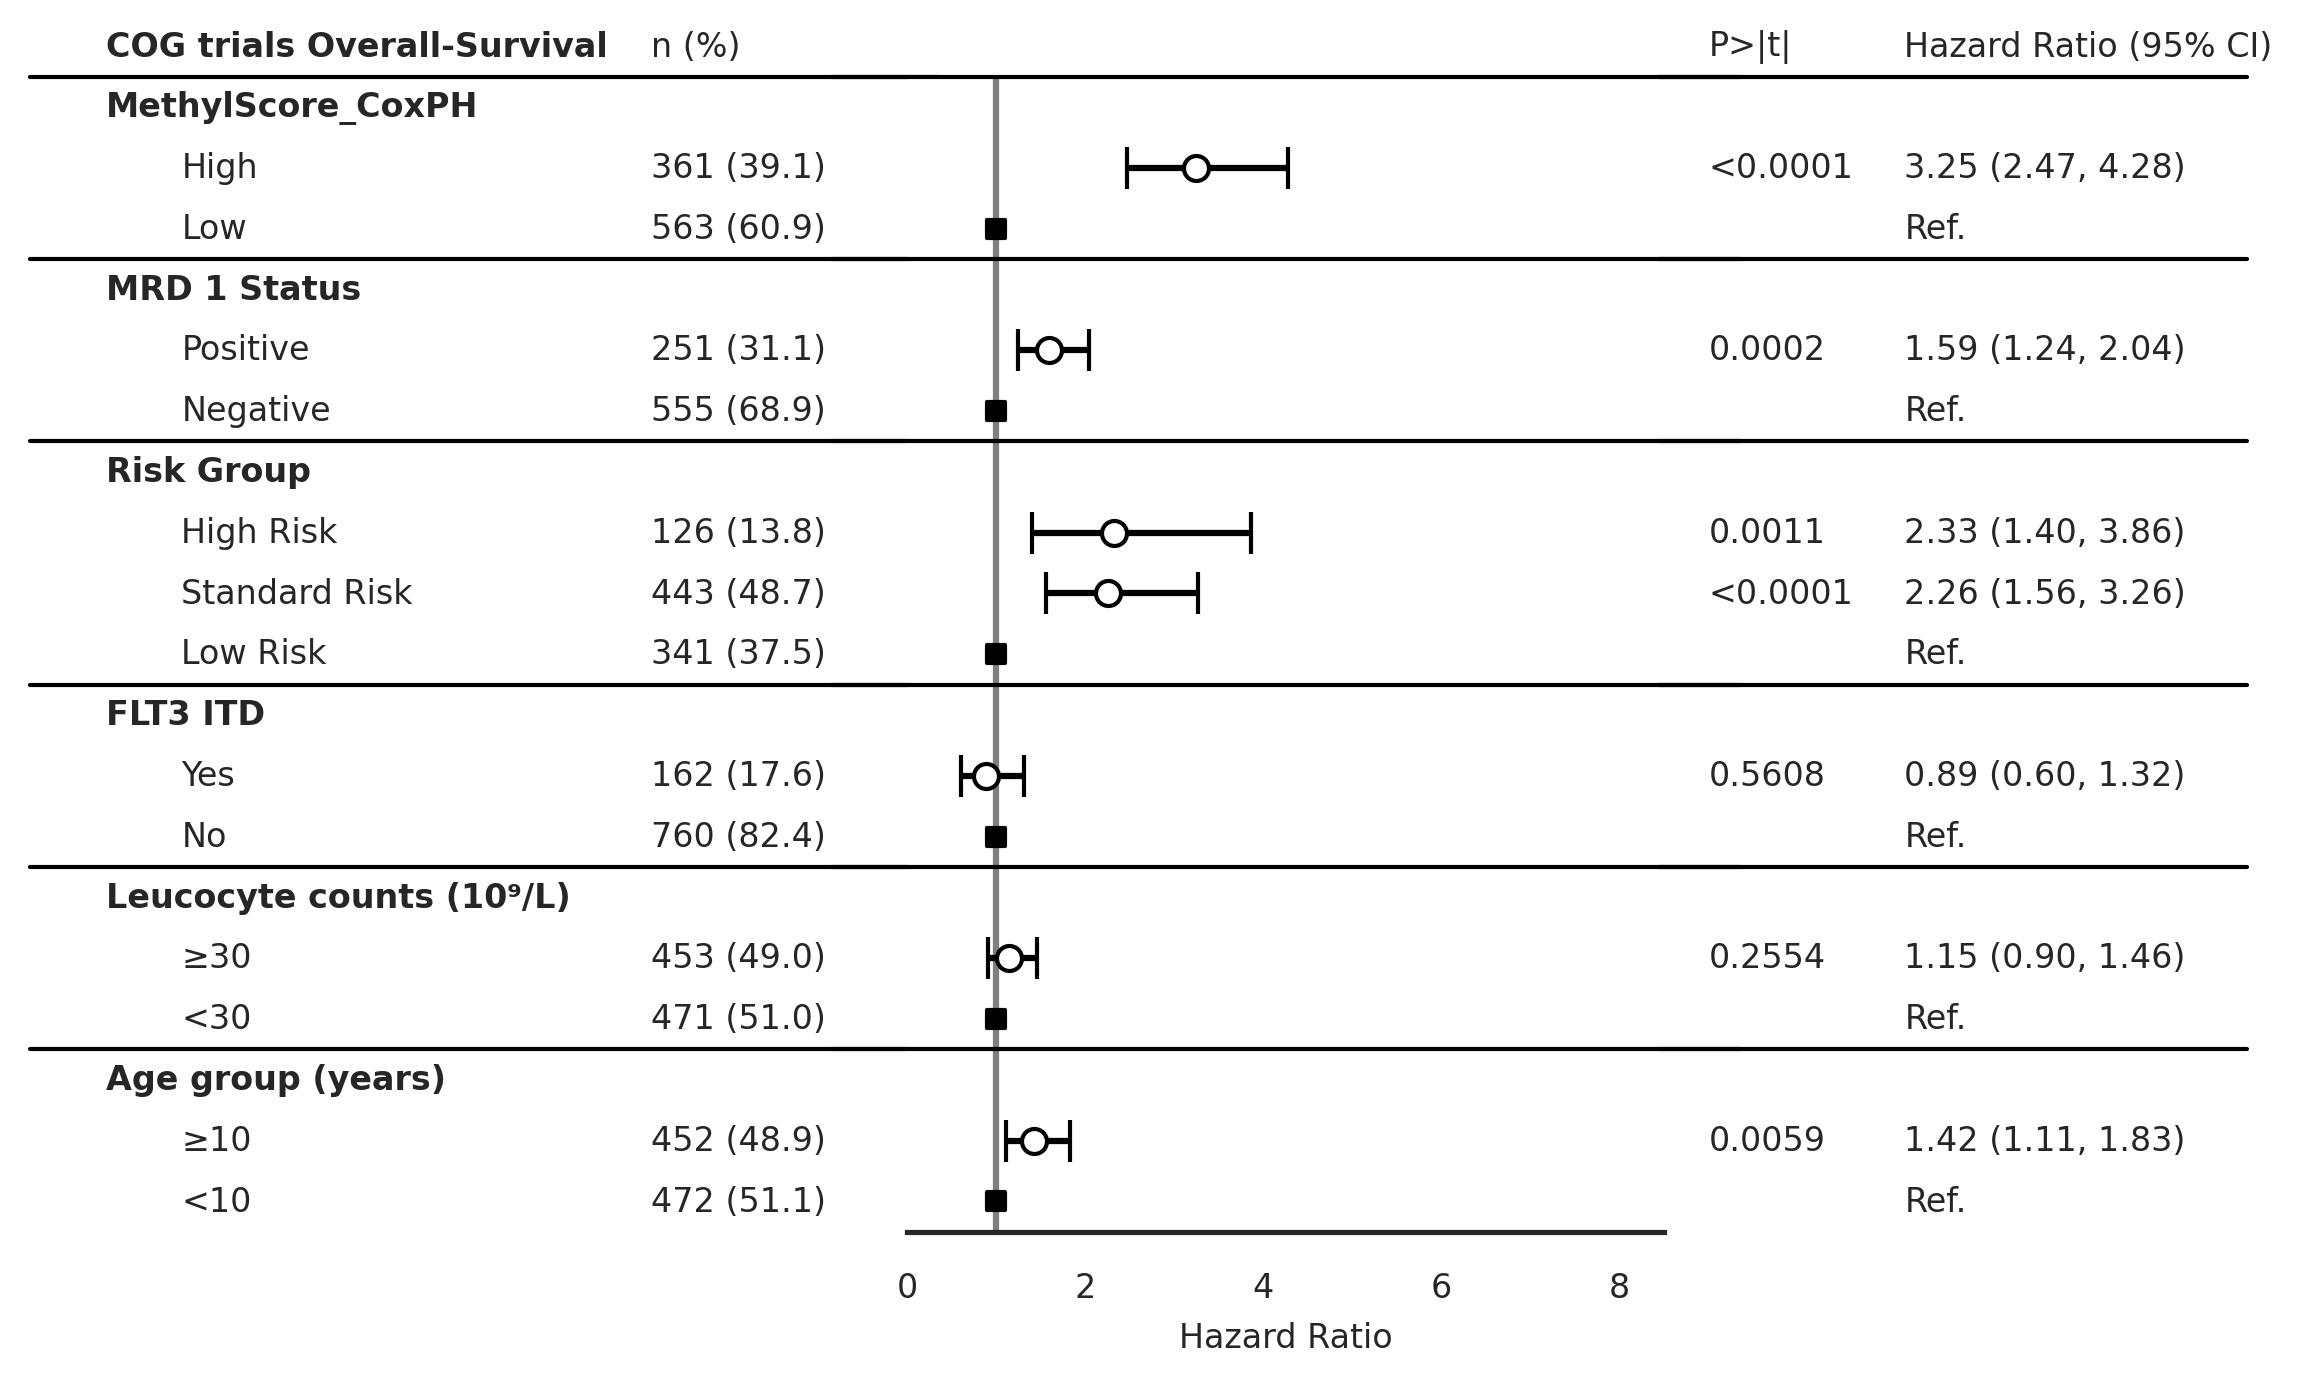

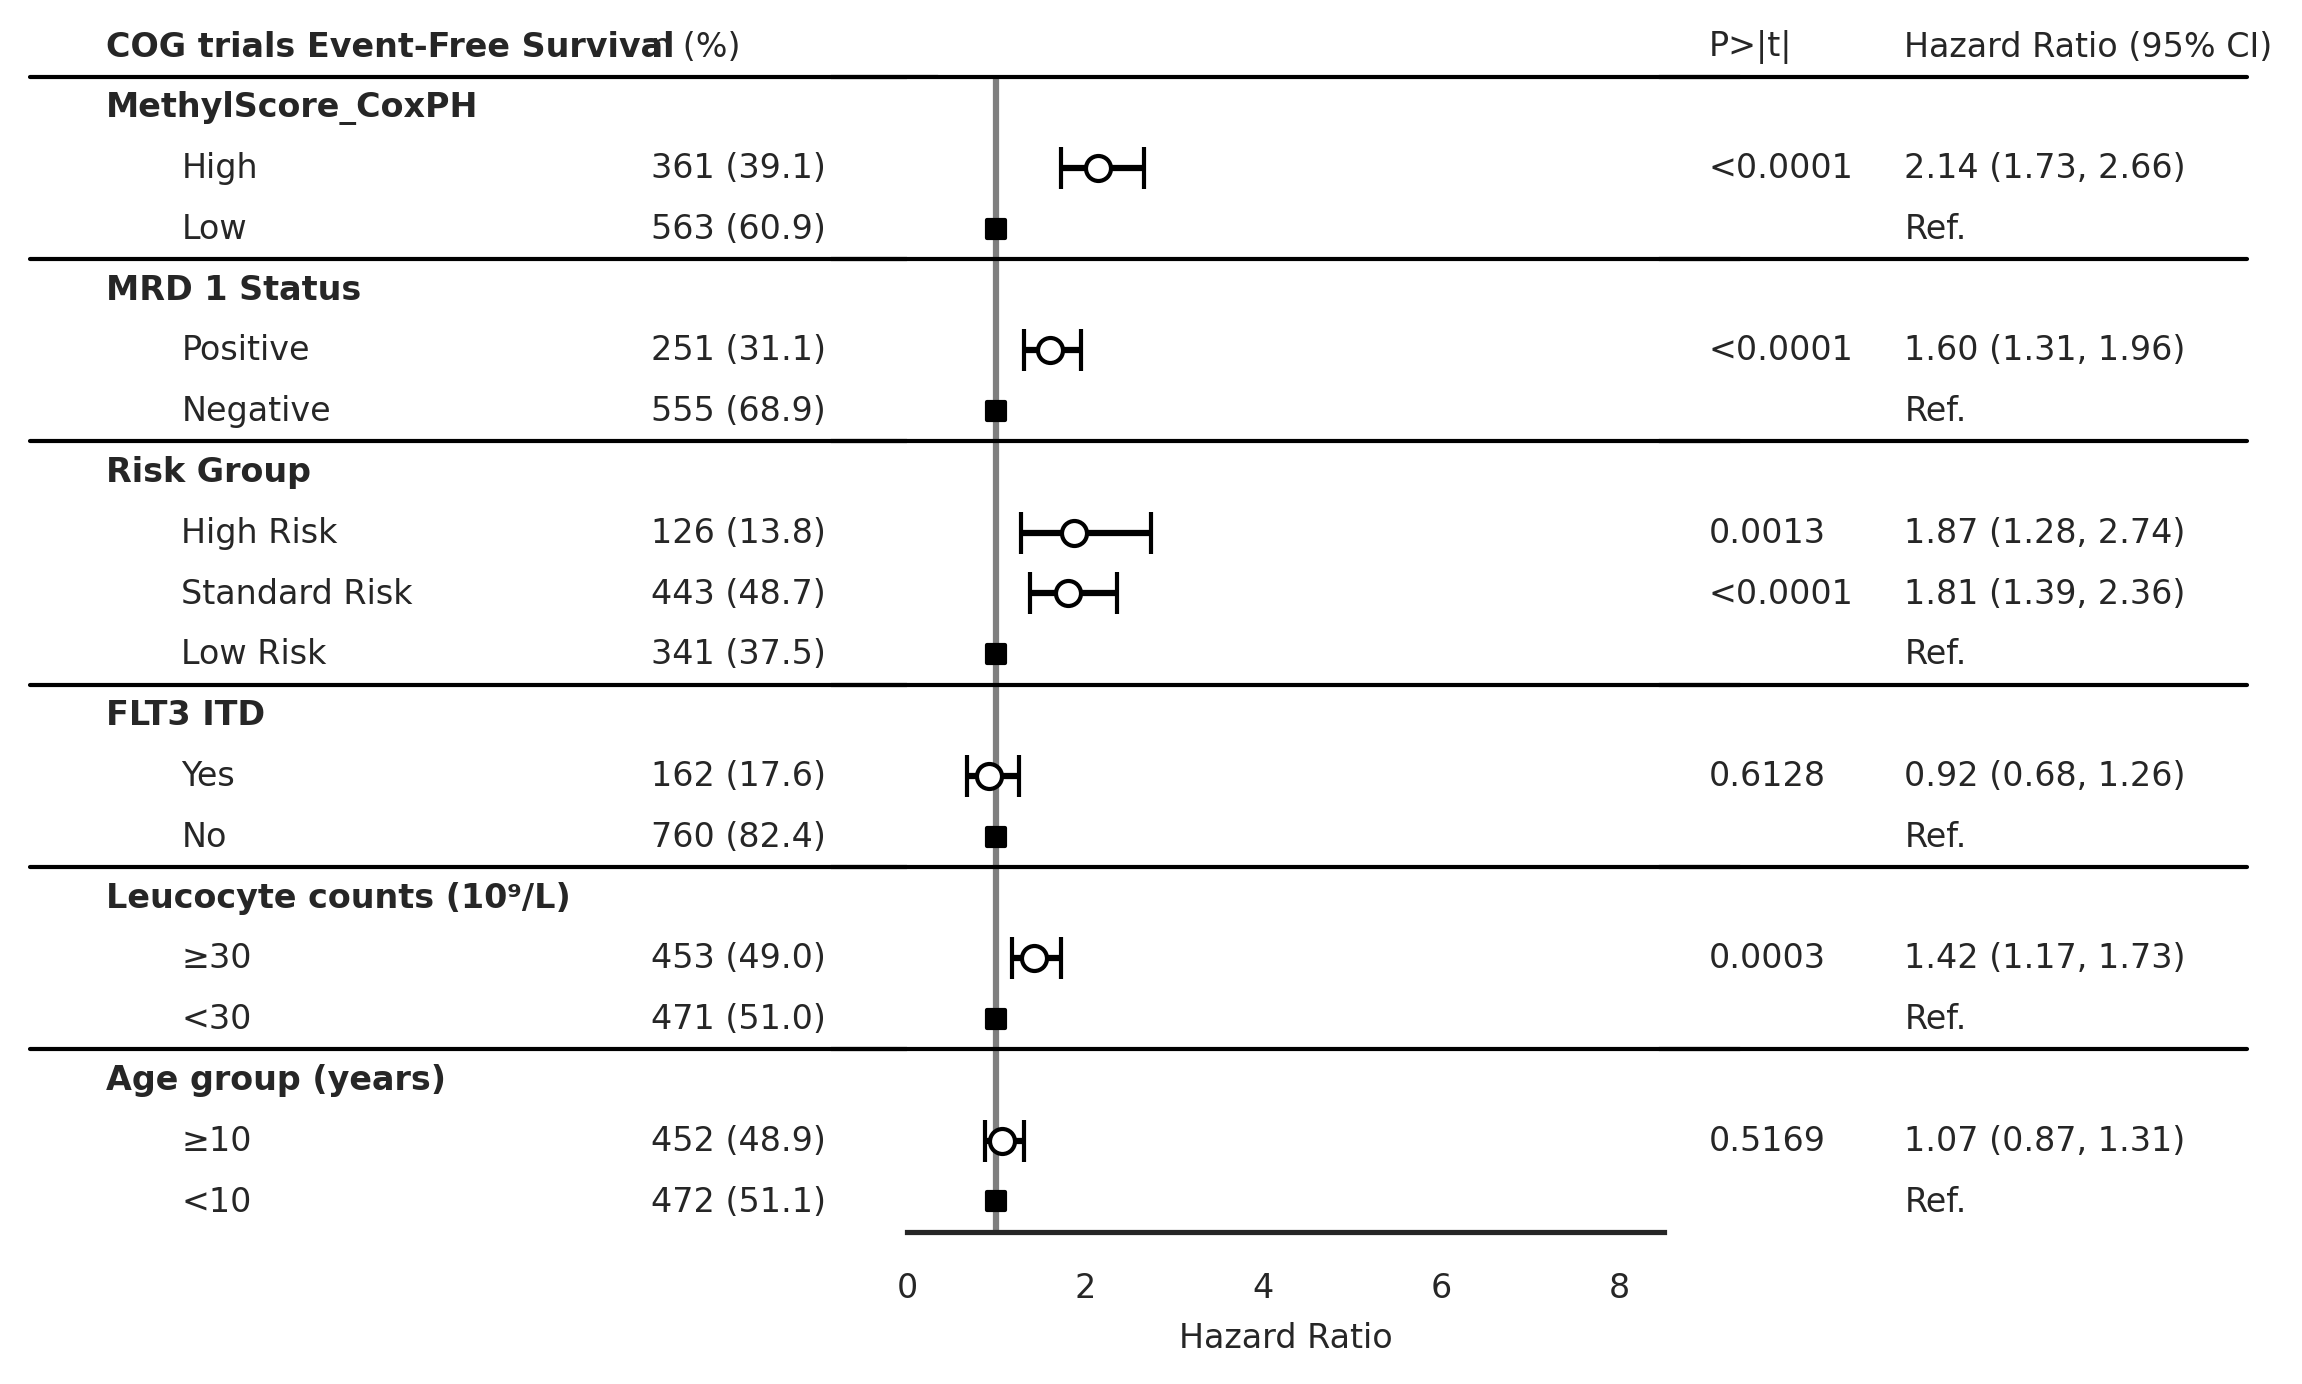

In [12]:
draw_forest_plot(time='os.time',
                    event='os.evnt',
                    df=df,
                    trialname='COG trials',
                    scorename=score_name,
                    save_plot=False)

draw_forest_plot(time='efs.time',
                    event='efs.evnt',
                    df=df,
                    trialname='COG trials',
                    scorename=score_name,
                    save_plot=False)

## Box Plots

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

High Risk vs. Standard Risk: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:3.325e-07 Stat=2.817e+01
Standard Risk vs. Low Risk: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:4.225e-79 Stat=3.568e+02
High Risk vs. Low Risk: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:4.232e-27 Stat=1.184e+02


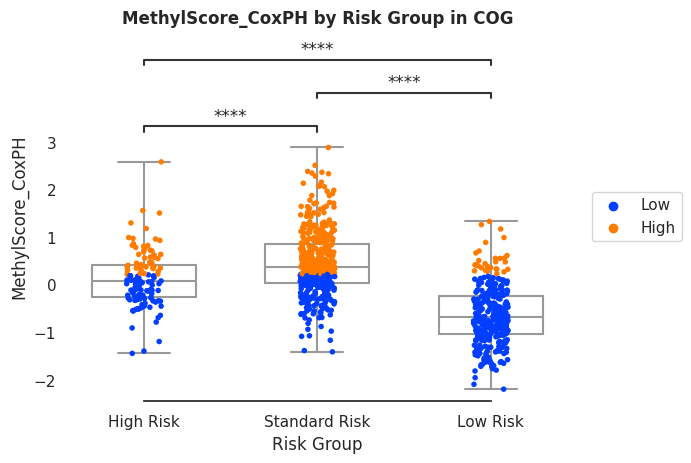

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Positive vs. Negative: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:2.989e-05 Stat=1.742e+01


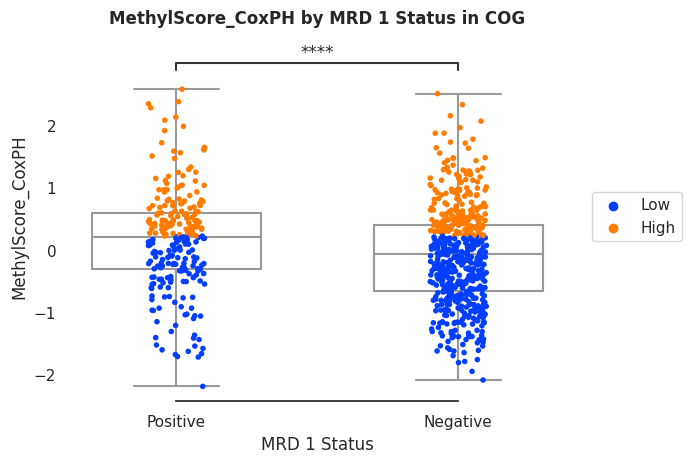

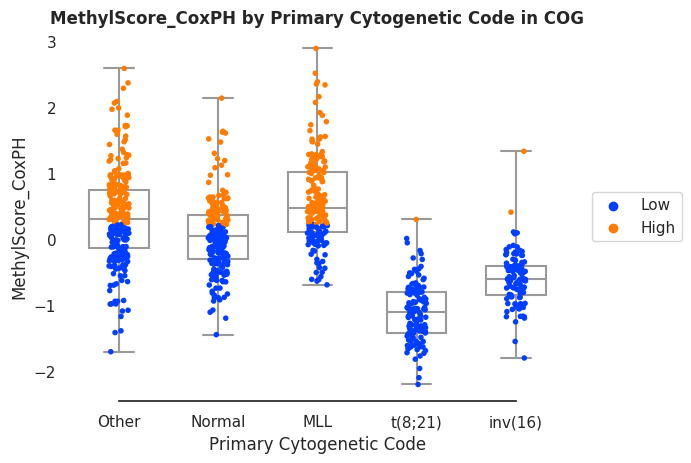

In [13]:
draw_boxplot(df=df_labels,x='Risk Group', y=score_name,
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='COG', hue=score_name + ' Categorical',
                save_plot=False, figsize=None)

draw_boxplot(df=df_labels,x='MRD 1 Status', y=score_name,
                order=['Positive','Negative'],
                trialname='COG', hue=score_name + ' Categorical',
                save_plot=False, figsize=None)

draw_boxplot(df=df_labels,x='Primary Cytogenetic Code', y=score_name,
                order='auto',
                trialname='COG', hue=score_name + ' Categorical',
                save_plot=False, figsize=None)

## Stacked Bar Plots

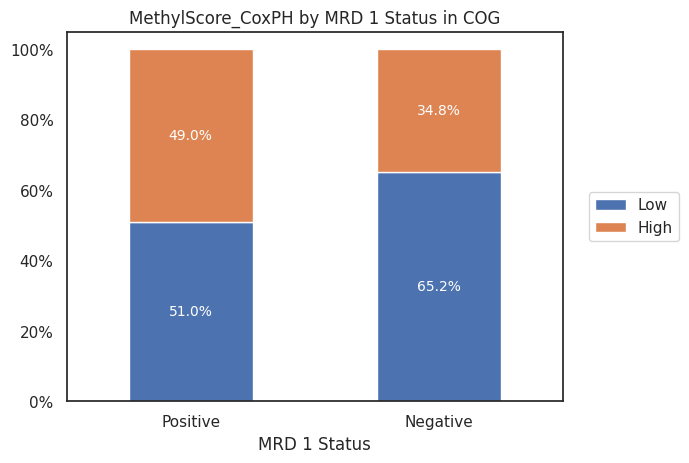

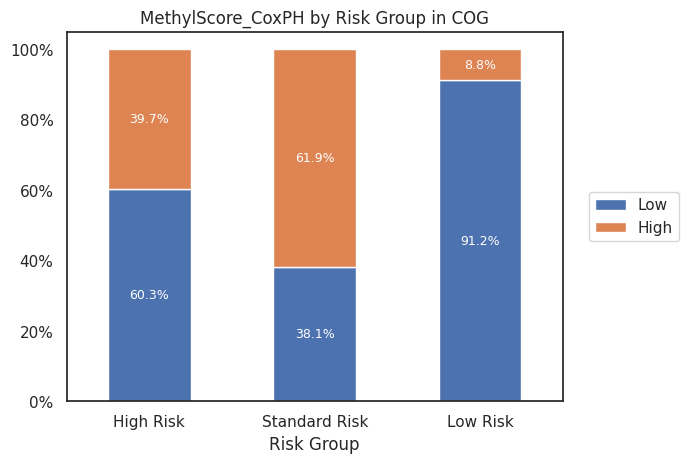

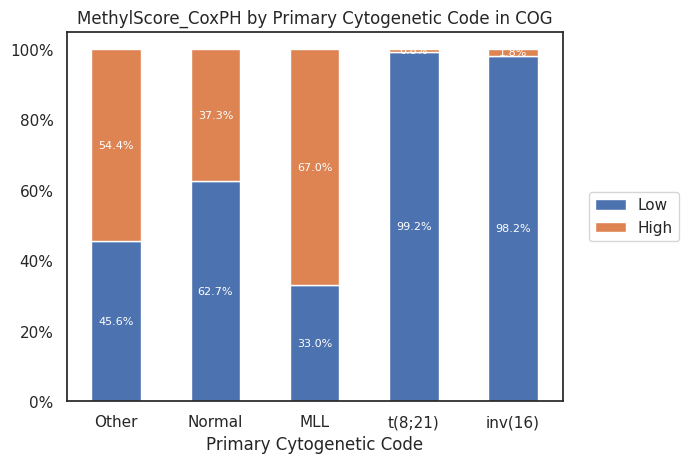

In [14]:
draw_stacked_barplot(df=df_labels,x='MRD 1 Status', y=score_name,
             order=['Positive','Negative'],
             trialname='COG', hue=score_name + ' Categorical',
             save_plot=False, figsize=None)

draw_stacked_barplot(df=df_labels,x='Risk Group', y=score_name,
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='COG', hue=score_name + ' Categorical',
                save_plot=False, figsize=None, fontsize=9)

draw_stacked_barplot(df=df_labels,x='Primary Cytogenetic Code', y=score_name,
                order='auto',
                trialname='COG', hue=score_name + ' Categorical',
                save_plot=False, figsize=None, fontsize=8)



## Fetch gene annotation

In [15]:
# Load manifest
zhou2016_probes = pd.read_csv('../Data/UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv',
                              sep='\t',index_col=0)[['chrm','start', 'end', 'GeneNames','GeneClasses','CGIPosition']]

# Get probes from Zhou et al. (2016) that are in ewasOS_un.index
mean_coefs_genes = zhou2016_probes.join(mean_coefs.to_frame('MethylScore Coefficients'), how='inner').sort_values(by='MethylScore Coefficients', ascending=False)

# `GeneNames`, `GeneClasses`, and `TranscriptIDs` columns contain multiple genes separated by `;` so we need to keep only the unique ones
mean_coefs_genes['GeneNames'] = mean_coefs_genes['GeneNames'].apply(lambda x: ';'.join(set(x.split(';'))))
mean_coefs_genes['GeneClasses'] = mean_coefs_genes['GeneClasses'].apply(lambda x: ';'.join(set(x.split(';'))))

from itables import show

show(mean_coefs_genes, classes="display nowrap cell-border")


## Patient Characteristics Table

In [16]:
from tableone import TableOne

columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)', 'BM Leukemic blasts (%)',
            'Risk Group', 'Clinical Trial','FLT3 ITD']

df_labels['Age (years)'] = df_labels['Age (years)'].astype(float)

mytable_cog = TableOne(df_labels, columns,
                        overall=False, missing=True,
                        pval=True, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']},
                        groupby=score_name + ' Categorical')

mytable_cog.tabulate(tablefmt="html", 
                        headers=[score_name,"",'Missing','High','Low','p-value','Statistical Test'])

MethylScore_CoxPH,,Missing,High,Low,p-value,Statistical Test
n,,,563,361,,
"Age (years), mean (SD)",,0,10.1 (6.1),8.4 (6.5),<0.001,Two Sample T-test
"Age group (years), n (%)",≥10,0,297 (52.8),155 (42.9),0.004,Chi-squared
,<10,,266 (47.2),206 (57.1),,
"Sex, n (%)",Female,0,277 (49.2),180 (49.9),0.898,Chi-squared
,Male,,286 (50.8),181 (50.1),,
"Race or ethnic group, n (%)",White,63,416 (79.2),264 (78.6),0.106,Chi-squared (warning: expected count < 5)
,Black or African American,,52 (9.9),48 (14.3),,
,Asian,,26 (5.0),16 (4.8),,
,American Indian or Alaska Native,,4 (0.8),1 (0.3),,


## Watermark

In [17]:
%load_ext watermark

In [18]:
# watermark with all libraries used in this notebook
%watermark -v -p pandas,seaborn,matplotlib,tableone,sklearn,lifelines,statannotations -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

pandas         : 2.0.2
seaborn        : 0.12.2
matplotlib     : 3.7.1
tableone       : 0.7.12
sklearn        : 1.2.2
lifelines      : 0.27.7
statannotations: 0.5.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

